## Imports

In [6]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist, pdist
from scipy.stats import pearsonr, ttest_ind, ttest_1samp, zscore
from statsmodels.stats.proportion import proportions_ztest

from khan_helpers import Experiment
from khan_helpers.constants import FIG_DIR
from khan_helpers.functions import symmetric_kl

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Set plotting params

In [7]:
plt.rcParams['pdf.fonttype'] = 42
sns.set_context('talk')
sns.set_style('white')
cmap = 'rocket_r'

## Load data

In [8]:
exp = Experiment()
forces_traj, bos_traj = exp.load_lecture_trajs()
questions_all = exp.load_question_vectors()
answers_all = exp.load_answer_vectors()
participants, avg_participant = exp.load_participants(load_avg=True)

In [9]:
# exclude questions where any possible answers contained no words (all numeric),
# yielding empty topic vectors (all topic weights == 1 / n_topics)
include = ~np.any((answers_all == 1 / answers_all.shape[2]).all(axis=2), axis=1)
qs_included =  np.where(include)[0]
questions = questions_all[include]
answers = answers_all[include]

In [10]:
# # sanity check: number of active topics for each question
# from scipy.stats import mode
# for question in questions:
#     vecs = np.round(question, decimals=6)
#     n_mode = mode(vecs).count[0]
#     print(vecs.shape[0] - n_mode)

### Do correct answers tend to be "closer" to the question than incorrect answers?
**no**

In [80]:
qa_dists = np.empty((answers.shape[:2]))
for q_ix in range(questions.shape[0]):
    qa_dists[q_ix] = cdist(np.atleast_2d(questions[q_ix]), 
                           answers[q_ix], 
                           'correlation').ravel()

# z-score within each answer set to normalize across questions
norm_qa_dists = zscore(qa_dists, ddof=1, axis=1)

# t-test for difference between correct and incorrect answers' distances
ttest_ind(norm_qa_dists[:, 0], norm_qa_dists[:, 1:].ravel())

Ttest_indResult(statistic=-0.8153949586285056, pvalue=0.4162118258892946)

### Do correct answers tend to be "closer" to the _lecture_ than incorrect answers?
**no**

In [122]:
# CONSIDER ONLY LECTURE-RELATED QUESTIONS
forces_qs = questions_all[qs_included[qs_included < 15]]
forces_ans = answers_all[qs_included[qs_included < 15]]
bos_qs = questions_all[qs_included[(15 <= qs_included) & (qs_included < 30)]]
bos_ans = answers_all[qs_included[(15 <= qs_included) & (qs_included < 30)]]

lec_ans_dists = np.empty((forces_qs.shape[0] + bos_qs.shape[0], 4))
# answers to Four Forces-related questions
for q_ix in range(forces_ans.shape[0]):
    lec_ans_dists[q_ix] = cdist(forces_traj, 
                                forces_ans[q_ix], 
                                'correlation').min(axis=0)
    
# answers to Birth of Stars-related questions
for q_ix in range(bos_ans.shape[0]):
    lec_ans_dists[q_ix + forces_ans.shape[0]] = cdist(bos_traj, 
                                                      bos_ans[q_ix], 
                                                      'correlation').min(axis=0)
    
# z-score within each answer set to normalize across questions
norm_lec_ans_dists = zscore(lec_ans_dists, ddof=1, axis=1)

# t-test for difference between correct and incorrect answers' distances
ttest_ind(norm_qa_dists[:, 0], norm_qa_dists[:, 1:].ravel())

Ttest_indResult(statistic=-0.8153949586285056, pvalue=0.4162118258892946)

### Do correct answers tend to be closest to corresponding question's closest point on lecture? (i.e., about the same lecture content)

### Do correct answers tend to be in the same "direction" from the lecture as the question?

### When answering incorrectly, do participants tend to choose the closest answer to the question?
- including correct answer
- excluding correct answer

### When answering incorrectly, do participants tend to choose the closest answer to the just-watched lecture?

### When answering incorrectly, do participants tend to choose the closest answer to the question's reference lecture?

### When answering incorrectly, do participants tend to choose the closest answer to the correponding question's closest lecture point?

### When answering incorrectly, do participants tend to choose an answer in the same direction from the reference lecture as the question?

### When answering incorrectly, do participants tend to choose an answer in the same direction from the just-watched lecture as the question?

### Are questions whose answers are closer to each other harder? -- no

In [8]:
# long dataframe with all participants' data
all_data = pd.concat((p.get_data() for p in participants))

In [9]:
# proportion of participants who answered each question correctly.
# Compute for lecture questions using only appearances after lecture has been 
# viewed; general knowledge questions from all qsets)
prop_success = np.empty(include.sum(), dtype=np.float)
for ix, q in enumerate(qs_included):
    if q < 15:
        qsets = [1, 2]
    elif 15 <= q < 30:
        qsets = [2]
    else:
        qsets = [0, 1, 2]
    qid = q + 1
    q_acc = all_data.loc[
        (all_data['qID'] == qid) & (all_data['qset'].isin(qsets)), 'accuracy'
    ]
    prop_success[ix] = q_acc.sum() / q_acc.shape[0]
    
# mean pairwise distance between answers
answer_spread = np.fromiter(
    (pdist(ans, 'correlation').mean() for ans in answers), 
    dtype=np.float64, 
    count=answers.shape[0]
)
# correlate the two
pearsonr(answer_spread, prop_success)

(0.1278168865536449, 0.4575475310403252)

## Are questions whose correct answers are closer to the question easier? -- no

In [10]:
# mean distance from question to answers
pearsonr(answer_dists[:, 0], prop_success)

(0.16087009943856934, 0.34861431613694777)

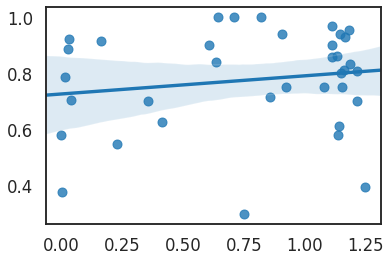

In [11]:
sns.regplot(answer_dists[:, 0], prop_success)

## Are questions where the closest answer is the correct one easier?

## Are people "tricked" by questions where the correct answer is not the closest?

## Are questions closer to the lecture easier? -- no

In [12]:
# consider only lecture-related questions answered after viewing that lecture
lec_qs_included = qs_included[qs_included < 30]
lec_qs_data = all_data.loc[all_data['qID'].isin(lec_qs_included + 1)]
data_after_viewing = lec_qs_data.loc[
    # lecture 1 questions viewed in 2nd or 3rd qset
    ((lec_qs_data['lecture'] == 1) & (lec_qs_data['qset'].isin([1, 2])))
    # or lecture 2 questions viewed in 3rd qset
    | ((lec_qs_data['lecture'] == 2) & (lec_qs_data['qset'] == 2))
]

# find proportion of participants who answered each question correctly
acc_after_viewing = np.empty(lec_qs_included.shape[0], dtype=np.float)
for ix, lq in enumerate(lec_qs_included + 1):
    q_acc = data_after_viewing.loc[data_after_viewing['qID'] == lq, 'accuracy']
    acc_after_viewing[ix] = q_acc.sum() / q_acc.shape[0]
    
# get topic vectors for included questions
ff_qs_mask = lec_qs_included < 15
lec_questions = questions_all[lec_qs_included]
ff_questions = lec_questions[ff_qs_mask]
bos_questions = lec_questions[~ff_qs_mask]

# compute (correlation) distance to closest point along lecture trajectory
ff_qs_dists = cdist(forces_traj, ff_questions, 'correlation').min(axis=0)
bos_qs_dists = cdist(bos_traj, bos_questions, 'correlation').min(axis=0)
lec_qs_dists = np.concatenate((ff_qs_dists, bos_qs_dists))

# correlate distance with proportion of correct answers
pearsonr(lec_qs_dists, acc_after_viewing)

(0.08525763810791807, 0.6662070529319926)

## Do correct answers tend to be closer to the lecture than incorrect answers? -- yes?

In [15]:
# consider lecture-related questions/answers
lec_answers = answers_all[lec_qs_included]

# separate forces and bos to compute distances to correct lecture;
# flatten across answers to each quetsion
ff_answers = lec_answers[ff_qs_mask].reshape(ff_qs_mask.sum() * 4, lec_answers.shape[2])
bos_answers = lec_answers[~ff_qs_mask].reshape((~ff_qs_mask).sum() * 4, lec_answers.shape[2])

# find distance to closest point on lecture trajectory
# HAVE TO USE KL DIVERGENCE HERE, CORRELATION GIVES TOO MANY NANs & INFs
ff_dists = cdist(forces_traj, ff_answers, symmetric_kl).min(axis=0).reshape(ff_qs_mask.sum(), 4)
bos_dists = cdist(bos_traj, bos_answers, symmetric_kl).min(axis=0).reshape((~ff_qs_mask).sum(), 4)

# recombine
lec_dists = np.concatenate((ff_dists, bos_dists))

# normalize across answers within each question (make distance to incorrect 
# answers a proportion of distance to correct answers)
correct_dists, incorrect_dists = tuple(map(np.squeeze, np.hsplit(lec_dists, [1])))
incorrect_dists_norm = (incorrect_dists / (correct_dists)[:, np.newaxis]).ravel()

# t-test incorrect answers' distances to question against null 
# that mean is the same as distance to correct answer
ttest_1samp(incorrect_dists_norm, popmean=1)

Ttest_1sampResult(statistic=3.2255791746327165, pvalue=0.0017992877674271558)

## If you draw a line along the shortest path from the question to the lecture, are correct answers closer to that line than incorrect answers?

##  When answering incorrectly, do people tend to pick the closest answer to the question? 
No -- they tend not to, significantly so

In [17]:
# compute (correlation) distance from question to each answer
question_answer_dists = np.empty((include.sum(), 4), dtype=np.float)
for i in range(4):
    d = np.diag(cdist(questions, answers[:, i], 'correlation'))
    question_answer_dists[:, i] = d
    
# get letter of closest answer to each question
closest_answers = np.array(list('ABCD'))[np.argmin(question_answer_dists, axis=1)]
# get response data for incorrect answers to included questions
qdata_incorrect = all_data.loc[
    (all_data['qID'].isin(qs_included)) & (all_data['accuracy'] == 0)
]

# find number of times closest answer was chosen instead of correct answer
n_chosen = 0
for i, qid in enumerate(qs_included + 1):
    qdata = qdata_incorrect.loc[qdata_incorrect['qID'] == qid]
    closest_ans = closest_answers[i]
    n_chosen += (qdata['response'] == closest_ans).sum()

# null hypothesis is probability of randomly choosing any incorrect answer (1/3)
proportions_ztest(n_chosen, qdata_incorrect.shape[0], value=1/3)

(-7.575738065800743, 3.570916358615618e-14)

## When answering incorrectly, do people tend to pick the closest answer to the lecture?

In [ ]:
# consider only lecture-related questions answered after viewing that lecture
# `data_after_viewing` & `lec_answers` computed above

# compute (correlation) distance from each answer to corresponding lecture
question_answer_dists = np.empty((include.sum(), 4), dtype=np.float)

In [115]:
lec_answers[ff_qs_mask]

(13, 4, 25)

In [26]:
# compute (correlation) distance from question to each answer
question_answer_dists = np.empty((include.sum(), 4), dtype=np.float)
for i in range(4):
    d = np.diag(cdist(questions, answers[:, i], 'correlation'))
    question_answer_dists[:, i] = d
    
# get letter of closest answer to each question
closest_answers = np.array(list('ABCD'))[np.argmin(question_answer_dists, axis=1)]
# get response data for incorrect answers to included questions
qdata_incorrect = all_data.loc[
    (all_data['qID'].isin(qs_included)) & (all_data['accuracy'] == 0)
]

# find number of times closest answer was chosen instead of correct answer
n_chosen = 0
for i, qid in enumerate(qs_included + 1):
    qdata = qdata_incorrect.loc[qdata_incorrect['qID'] == qid]
    closest_ans = closest_answers[i]
    n_chosen += (qdata['response'] == closest_ans).sum()

# null hypothesis is probability of randomly choosing any incorrect answer (1/3)
proportions_ztest(n_chosen, qdata_incorrect.shape[0], value=1/3)

(-7.575738065800743, 3.570916358615618e-14)